# Import relevant files

In [1]:
from src.mtl import MultiTaskModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Instantiate the Model

In [2]:
model = MultiTaskModel(backbone_pth='models/backbone')

Model loaded from models/backbone


/Users/manan/Desktop/Leetcode/Fetch Assesment/src/embedding_model.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.projection.load_state_dict(torch.load(f"{path}/pr

#### Task A is Sentence classification into 4 categories
#### Task B is Sentiment Analysis with 3 categories (Positve, Negative or Neutral)

#### Assuming that input data (sentences) have two labels: one for classification and one for sentiment

## Sample Synthetic Data


In [3]:
# Synthetic data load from a CSV file for demonstration. 
# NOTE: Data was generated using generative AI.

data = pd.read_csv('data/synthetic_data.csv')

class NewsSentimentDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return row["sentence"], row["labelA"], row["labelB"]


train_dataloader = DataLoader(NewsSentimentDataset(data[:90]), batch_size=16, shuffle=True)
val_dataloader   = DataLoader(NewsSentimentDataset(data[90:]), batch_size=16, shuffle=False)

for sentences, labelsA, labelsB in train_dataloader:
    print(sentences)
    print(labelsA, labelsB)
    break

('Art exhibition launches innovative program.', 'City Council encounters unexpected setbacks.', 'Cybersecurity firm releases its annual report.', 'Award-winning director launches innovative program.', 'Open-source community releases its annual report.', 'Broadway show is criticized for lack of transparency.', 'Tech giant launches innovative program.', 'The Senate delays project rollout.', 'The Senate partners with international organizations.', 'Tennis Grand Slam winner is criticized for lack of transparency.', 'Film festival receives widespread acclaim.', 'Pop music artist celebrates major victory.', 'Open-source community faces scrutiny over recent decisions.', 'The Ministry of Finance encounters unexpected setbacks.', 'Blockbuster movie receives widespread acclaim.', 'Election Commission updates its policy framework.')
tensor([3, 0, 2, 3, 2, 3, 2, 0, 0, 1, 3, 3, 2, 0, 3, 0]) tensor([0, 2, 1, 0, 1, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 1])


# Training Loop (Task 4)

In [4]:
# BASELINE METRICS: Accuracy, Recall, Precision

accA, accB, recallA, recallB, precisionA, precisionB = model.metrics(val_dataloader)
print(f"Validation Accuracy: A: {accA:.4f}, B: {accB:.4f}")
print(f"Validation Recall: A: {recallA:.4f}, B: {recallB:.4f}")
print(f"Validation Precision: A: {precisionA:.4f}, B: {precisionB:.4f}")

Validation Accuracy: A: 0.2000, B: 0.3000
Validation Recall: A: 0.0000, B: 0.0000
Validation Precision: A: 0.0000, B: 0.0000


## Training loop - Version 1 (Three phase training)

All backbone layers frozen
Task A head unfrozen
Task B head unfrozen
Model saved to best_model
Model saved to best_model
Epoch 1/10 - train_loss: 2.4769  val_loss: 2.4849  A_acc: 20.00%  B_acc: 30.00%
Model saved to best_model
Model saved to best_model
Epoch 2/10 - train_loss: 2.4361  val_loss: 2.4534  A_acc: 20.00%  B_acc: 30.00%
Model saved to best_model
Model saved to best_model
Epoch 3/10 - train_loss: 2.3825  val_loss: 2.4009  A_acc: 43.33%  B_acc: 30.00%
Model saved to best_model
Model saved to best_model
Epoch 4/10 - train_loss: 2.3200  val_loss: 2.3658  A_acc: 50.00%  B_acc: 30.00%
Model saved to best_model
Model saved to best_model
Epoch 5/10 - train_loss: 2.2564  val_loss: 2.3230  A_acc: 50.00%  B_acc: 30.00%
Model saved to best_model
Model saved to best_model
Epoch 6/10 - train_loss: 2.1843  val_loss: 2.2705  A_acc: 53.33%  B_acc: 30.00%
Model saved to best_model
Model saved to best_model
Epoch 7/10 - train_loss: 2.1111  val_loss: 2.2342  A_acc: 60.00%  B_acc: 43.33%
Model s

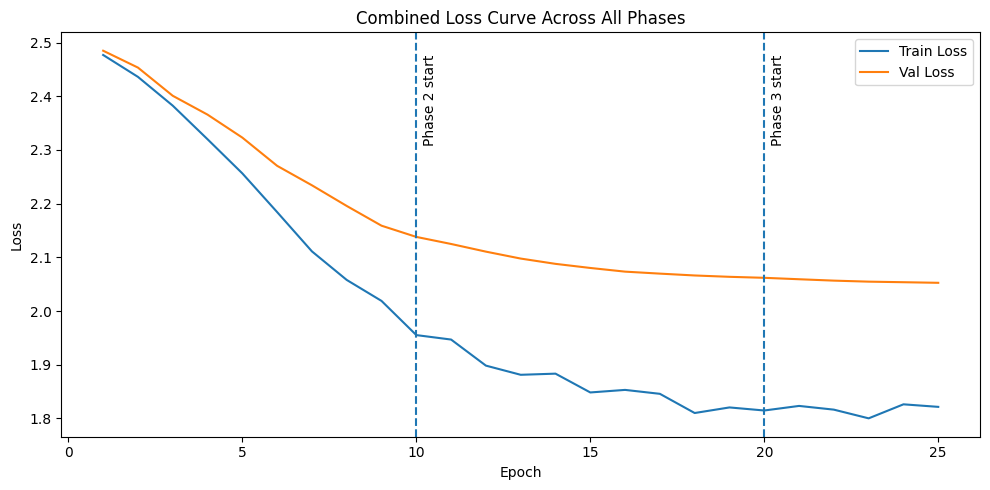

In [5]:
# Assuming that train_dataloarder and val_dataloader are defined

# Losses
lossA = nn.CrossEntropyLoss()
lossB = nn.CrossEntropyLoss()

# Phase 1: Epochs 1–10 (backbone frozen, train projection + both heads, lr: 1e-3)
model.freeze_backbone()            # lock all Transformer layers
model.unfreeze_projection()        #  unfreeze projection layer
model.unfreeze_taskA_head()        #  unfreeze Task A head
model.unfreeze_taskB_head()        #  unfreeze Task B head

opt1 = optim.AdamW([
    {'params': model.backbone.projection.parameters(), 'lr': 1e-3},
    {'params': model.taskA_head.parameters(),          'lr': 1e-3},
    {'params': model.taskB_head.parameters(),          'lr': 1e-3},
])
sched1 = StepLR(opt1, step_size=3, gamma=0.5)

history1 = model.fit(
    train_dataloader,
    val_dataloader,
    opt1,
    lossA,
    lossB,
    epochs=10,
    scheduler=sched1
)

# Phase 2: Epochs 11–20 (unfreeze top 2 Transformer layers, lr backbone=1e-5, heads+proj=1e-4)
model.freeze_backbone()            # re‐freeze all backbone layers
model.unfreeze_backbone(num=2)     # unfreeze just the last 2 backbone layers
model.unfreeze_projection()        # projection unfrozen
model.unfreeze_taskA_head()        # headA unfrozen
model.unfreeze_taskB_head()        # headB unfrozen

# collect trainable backbone params
backbone_params = [p for p in model.backbone.model.parameters() if p.requires_grad]
head_and_proj = (
    list(model.backbone.projection.parameters()) +
    list(model.taskA_head.parameters()) +
    list(model.taskB_head.parameters())
)

opt2 = optim.AdamW([
    {'params': backbone_params, 'lr': 1e-5},
    {'params': head_and_proj,    'lr': 1e-4},
])
sched2 = StepLR(opt2, step_size=3, gamma=0.5)

history2 = model.fit(
    train_dataloader,
    val_dataloader,
    opt2,
    lossA,
    lossB,
    epochs=10,
    scheduler=sched2
)

# hase 3: Epochs 21-25 (gradual unfreeze:fully unfreeze and fine‐tune with lower LRs)
model.unfreeze_backbone()          # all layers now trainable
model.unfreeze_projection()
model.unfreeze_taskA_head()
model.unfreeze_taskB_head()

all_backbone = list(model.backbone.model.parameters())
all_proj_and_heads = (
    list(model.backbone.projection.parameters()) +
    list(model.taskA_head.parameters()) +
    list(model.taskB_head.parameters())
)

opt3 = optim.AdamW([
    {'params': all_backbone,       'lr': 1e-6},
    {'params': all_proj_and_heads, 'lr': 1e-5},
])
sched3 = StepLR(opt3, step_size=3, gamma=0.5)

history3 = model.fit(
    train_dataloader,
    val_dataloader,
    opt3,
    lossA,
    lossB,
    epochs=5,
    scheduler=sched3
)
# stitch together the losses from each phase
train_losses = history1['train_loss'] + history2['train_loss'] + history3['train_loss']
val_losses   = history1['val_loss']   + history2['val_loss']   + history3['val_loss']

total_epochs = len(train_losses)
epochs = list(range(1, total_epochs + 1))

# compute phase boundaries
p1_end = len(history1['train_loss'])
p2_end = p1_end + len(history2['train_loss'])

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')

#draw and label the phase splits
for idx, bound in enumerate([p1_end, p2_end], start=1):
    plt.axvline(bound, linestyle='--')
    plt.text(bound + 0.2, max(train_losses), f'Phase {idx+1} start', rotation=90, va='top')

plt.title('Combined Loss Curve Across All Phases')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Evaluation

In [ ]:
# loading the best trained model
model = MultiTaskModel(backbone_pth='models/backbone')
model.load('best_model')

Model loaded from models/backbone
Model loaded from best_model


/Users/manan/Desktop/Leetcode/Fetch Assesment/src/embedding_model.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.projection.load_state_dict(torch.load(f"{path}/pr

MultiTaskModel(
  (taskA_head): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=4, bias=True)
  )
  (taskB_head): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [24]:
# FINAL METRICS
f_accA, f_accB, f_recallA, f_recallB, f_precisionA, f_precisionB = model.metrics(val_dataloader)
print(f"Final Validation Accuracy: A: {f_accA:.4f}, B: {f_accB:.4f}")
print(f"Final Validation Recall: A: {f_recallA:.4f}, B: {f_recallB:.4f}")
print(f"Final Validation Precision: A: {f_precisionA:.4f}, B: {f_precisionB:.4f}")

Final Validation Accuracy: A: 0.8000, B: 0.6333
Final Validation Recall: A: 1.0000, B: 0.6000
Final Validation Precision: A: 1.0000, B: 0.8571


## Qualitative Analysis

In [25]:
mappingA = {0: "Politics", 1: "Sports", 2: "Technology", 3: "Entertainment"}
mappingB = {0: "Positive", 1: "Neutral", 2: "Negative"}

sentence = "Baseball player hits an amazing home run!"
predA, predB = model.predict(sentence)
print(f"Predicted Task A: {mappingA[predA.to('cpu').item()]}, Task B: {mappingB[predB.to('cpu').item()]}")

sentence = "Senator faces criticism over recent tax policy changes."
predA, predB = model.predict(sentence)
print(f"Predicted Task A: {mappingA[predA.to('cpu').item()]}, Task B: {mappingB[predB.to('cpu').item()]}")

Predicted Task A: Sports, Task B: Positive
Predicted Task A: Politics, Task B: Negative


## Alternate version - Training All Parameters together

In [ ]:
# UNCOMMENT THIS BLOCK TO TRAIN THE MODEL USING ALTERNATE STRATEGY

# # 1) Make sure everything is unfrozen so gradients are computed
# model.unfreeze_backbone()
# model.unfreeze_projection()
# model.unfreeze_taskA_head()
# model.unfreeze_taskB_head()

# # 2) Losses
# class_lossA = nn.CrossEntropyLoss()
# sentiment_lossB = nn.CrossEntropyLoss()

# # 3) Optimizer with parameter groups
# model_optimizer = optim.AdamW([
#     {'params': model.backbone.model.parameters(),     'lr': 1e-5}, # slower backbone LR to ensure backbone is not overfitted
#     {'params': model.backbone.projection.parameters(), 'lr': 1e-4},
#     {'params': model.taskA_head.parameters(),          'lr': 1e-4},
#     {'params': model.taskB_head.parameters(),          'lr': 1e-4},
# ])

# # 4) Scheduler
# scheduler = StepLR(model_optimizer, step_size=2, gamma=0.5)

# # 5) Train/val loop via your fit helper
# history = model.fit(train_loader=train_dataloader,
#                     val_loader=val_dataloader,
#                     optimizer=model_optimizer,
#                     lossA=class_lossA,
#                     lossB=sentiment_lossB,
#                     epochs=20,
#                     scheduler=scheduler
#                     )

# # 6) Plotting
# plt.plot(history['train_loss'], label='Train Loss')
# plt.plot(history['val_loss'], label='Validation Loss')
# plt.title('Losses')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()